# A Non-Asymptotic Analysis for Stein Variational Gradient Descent

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform
import scipy
import seaborn as sns
sns.set_theme(style='darkgrid')
from scipy.stats import gaussian_kde


## Functions

In [ ]:
def visu_1d(target_density, x, grad=None, grad_prob=None, repulse=None,
            x_lim=(-5, 5), n_pts_x=200, title=""):
    """
    Visualization of the target density in 1 dimension, with the particles and their gradients
    """
    n_pts_x = x.shape[0]
    # Create the grid of values
    x_val = np.linspace(x_lim[0], x_lim[1], n_pts_x)
    xx = np.expand_dims(x_val, axis=1)

    # Compute the density
    density_values = target_density(xx)
    density_values = density_values / density_values.sum()

    # Plot the density
    plt.plot(x_val, density_values, label="Target distribution")
    plt.xlabel("X")
    plt.ylabel("Density")
    plt.title(title)

    # Plot the points
    plt.scatter(x, np.zeros_like(x), color="black", marker=".")

    kde = gaussian_kde(x.reshape(-1,))
    mu = kde.evaluate(x_val)
    mu = mu / mu.sum()
    plt.plot(x_val, mu, label="Current distribution")

    plt.legend()

    if grad_prob is not None:
        grad_plot = grad_prob
        plt.quiver(x.flatten(), np.zeros_like(x), grad_plot.flatten(), np.zeros_like(grad_plot), color="blue", scale_units="xy", angles="xy", scale=1, width=0.005)

    if repulse is not None:
        grad_plot = repulse
        plt.quiver(x.flatten(), np.zeros_like(x), grad_plot.flatten(), np.zeros_like(grad_plot), color="green", scale_units="xy", angles="xy", scale=1, width=0.005)


    if grad is not None:
        grad_plot = grad
        plt.quiver(x.flatten(), np.zeros_like(x), grad_plot.flatten(), np.zeros_like(grad_plot), color="red", scale_units="xy", angles="xy", scale=1, width=0.005)

In [ ]:
def visu_2d(target_density, x, grad=None, grad_prob=None, repulse=None,
            x_lim=(-5, 5), n_pts_x=101, title=""):
    """
    Visualization of the target density in 2 dimensions, with the particles and their gradients
    """
    x1_lim = x_lim
    x2_lim = x_lim

    n_pts_x1 = n_pts_x
    n_pts_x2 = n_pts_x

    # Create the grid of values
    x1_val = np.linspace(x1_lim[0], x1_lim[1], n_pts_x1)
    x2_val = np.linspace(x2_lim[0], x2_lim[1], n_pts_x2)

    x1, x2 = np.meshgrid(x1_val, x2_val)
    xx = np.concatenate((np.expand_dims(x1, axis=2), np.expand_dims(x2, axis=2)), axis=2)

    # Compute the density
    density_values = target_density(xx.reshape(-1, 2))
    density_values = density_values.reshape(n_pts_x2, n_pts_x1)

    # Plot the density
    x1_labels = np.round(np.linspace(x1_lim[0], x1_lim[1], 11), 1)
    x1_ticks = np.linspace(0, n_pts_x1-1, 11, dtype='int')
    x2_labels = np.round(np.linspace(x2_lim[0], x2_lim[1], 11), 1)
    x2_ticks = np.linspace(0, n_pts_x2-1, 11, dtype='int')

    plt.imshow(density_values, origin='lower')
    plt.xticks(ticks=x1_ticks, labels=x1_labels)
    plt.yticks(ticks=x2_ticks, labels=x2_labels)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.colorbar()


    scale = np.diag([(n_pts_x1-1) / (x1_lim[1] - x1_lim[0]), (n_pts_x2-1) / (x2_lim[1] - x2_lim[0])])
    x_plot = (x -np.array([x1_lim[0], x2_lim[0]])) @ scale

    # Plot the gradients
    if grad_prob is not None:
        grad_plot = grad_prob @ scale
        for pt, pt_grad in zip(x_plot, grad_plot):
            plt.arrow(pt[0], pt[1], pt_grad[0], pt_grad[1], color="blue", head_width=1, head_length=1)

    if repulse is not None:
        grad_plot = repulse @ scale
        for pt, pt_grad in zip(x_plot, grad_plot):
            plt.arrow(pt[0], pt[1], pt_grad[0], pt_grad[1], color="green", head_width=1, head_length=1)

    if grad is not None:
        grad_plot = grad @ scale
        for pt, pt_grad in zip(x_plot, grad_plot):
            plt.arrow(pt[0], pt[1], pt_grad[0], pt_grad[1], color="red", head_width=1, head_length=1)

    # Plot the points
    plt.scatter(x_plot[:, 0], x_plot[:, 1], color="teal", marker=".", label="Current distribution")

    plt.legend()

In [ ]:
def visu(target_density, x=None, grad=None, grad_prob=None, repulse=None,
         x_lim=(-5, 5), n_pts_x=101, title=""):
    """
    Visualization of the target density in 1 or 2 dimensions
    """
    d = x.shape[-1]
    if d == 1:
      visu_1d(target_density, x=x, grad=grad, grad_prob=grad_prob, repulse=repulse,
              x_lim=x_lim, n_pts_x=n_pts_x, title=title)
      return
    if d == 2:
      visu_2d(target_density, x=x, grad=grad, grad_prob=grad_prob, repulse=repulse,
              x_lim=x_lim, n_pts_x=n_pts_x, title=title)
      return

In [ ]:
def gaussian_kernel(points, h=None):
    dist = cdist(points, points)
    n, d = points.shape
    if h is None:
        h = np.median(dist) ** 2 / np.log(1 + n)

    ker = np.exp(- dist**2 / h)

    particles_reshaped = points[:, np.newaxis, :]
    diff_matrix = points[np.newaxis, :, :] - particles_reshaped
    dK = 2 * diff_matrix * ker[:, :, np.newaxis] / h

    return ker, dK, h

In [ ]:
def matrices_for_Istein(x, gld, ker, h):

        init_dist = pdist(x)
        pairwise_dists = squareform(init_dist)

        # kernel matrix
        kernal_xj_xi = np.exp(- pairwise_dists ** 2 / h)

        # first derivative
        d0=np.matrix(x - x[:,np.newaxis])
        d1=kernal_xj_xi* (-1 /h)
        d_kernal_xj_xi=np.multiply(d0,d1)


        # second derivatives : nabla_{xi,xj} k(xi,x) = ( k(xi,x) + (xi-x)^2 * k(xi,x) ) * 2/h
        d1= kernal_xj_xi * 4 / h
        d2= np.multiply(pairwise_dists**2, kernal_xj_xi) * 8/(h**2)
        d2_kernal_xj_xi=(d1-d2)

        # scores of nabla log pi(xi)
        d_log_pi_xi=np.copy(gld)

        return kernal_xj_xi, d_kernal_xj_xi, d2_kernal_xj_xi, d_log_pi_xi

def computeIstein(kernal_xj_xi, d_kernal_xj_xi, d2_kernal_xj_xi, d_log_pi_xi):

        n = kernal_xj_xi.shape[0]
        d_log_pi_xj = d_log_pi_xi[:,np.newaxis]

        D = np.zeros((n,n))

        # first term with second derivative
        A = d2_kernal_xj_xi
        D+=A

        # cross terms
        b1= d_log_pi_xj + d_log_pi_xi
        b1=b1.reshape((n,n))
        B=np.multiply(b1,d_kernal_xj_xi)
        D+=B

        # last term
        dot_product_d_log_pi=np.multiply(d_log_pi_xi, d_log_pi_xj)
        dot_product_d_log_pi=dot_product_d_log_pi.reshape((n,n))
        C=np.multiply(dot_product_d_log_pi,kernal_xj_xi)
        D+=C

        istein=np.sum(D)/(n**2)
        return istein

In [ ]:
class KLDivergence:
    def __init__(self, dimension, target, n_pts_dim=10, min_pt=-5, max_pt=5):
        self.dim = dimension
        self.target = target
        self.n_pts_dim = n_pts_dim
        self.min_pt = min_pt
        self.max_pt = max_pt
        self.cube_volume = ((max_pt - min_pt)/n_pts_dim) ** dimension

        # Create a grid of points
        coords = []
        for d in range(dimension):
            coords.append(np.linspace(min_pt, max_pt, n_pts_dim))
        grid_points = np.meshgrid(*coords)
        grid_points = np.moveaxis(np.array(grid_points), 0, -1)
        grid_points = grid_points.reshape(n_pts_dim**dimension, dimension)
        self.grid_points = grid_points

        # Compute the target density on the grid
        target_density_val = target.density(grid_points)
        target_density_val /= target_density_val.sum()
        target_density_val /= self.cube_volume
        self.target_density_val = target_density_val

    def __call__(self, points, h=None):
        # Estimate the density of mu at the grid points
        mu_density = gaussian_kde(points.T, bw_method=h)
        mu_val = mu_density.evaluate(self.grid_points.T)
        mu_val /= mu_val.sum() # Renormalize to avoid boundary effects
        mu_val /= self.cube_volume

        # Compute the KL integral
        pos_ind = mu_val > 0 # Avoid computing log(0), considering 0 * log(0) = 0
        KL = np.sum(mu_val[pos_ind] * np.log(mu_val[pos_ind] / self.target_density_val[pos_ind]))
        KL *= self.cube_volume
        return KL


In [ ]:
from tqdm import tqdm
class SVGD():
    def __init__(self, points, target):
        self.points = points
        self.target = target

    def optimize(self, n_iter, lr=0.01, h=None, lamb=5e-4, path=None):
        n, d = self.points.shape
        KL = list()
        grad_prob_list = list()
        grad_repulse_list = list()
        grad_tot_list = list()
        KL_exp = list()
        kl_div = KLDivergence(d, self.target)
        Istein = list()
        grad_prob_plot = list()
        grad_repulse_plot = list()
        grad_tot_plot = list()
        points_plot = list()
        display_step = (n_iter) // 5

        for iter in tqdm(range(n_iter)):
            # SVGD iteration
            ker, dK, h_ = gaussian_kernel(self.points, h=h)
            gld = self.target.grad_log_density(self.points)
            grad_prob = ker @ gld / n
            grad_repulse = dK.sum(axis=0) / n
            grad_tot = grad_prob + grad_repulse

            # Keep in mind to plot after
            grad_prob_list.append(np.linalg.norm(grad_prob))
            grad_repulse_list.append(np.linalg.norm(grad_repulse))
            grad_tot_list.append(np.linalg.norm(grad_tot))

            # compute Istein
            if d==1:
                kernal_xj_xi, d_kernal_xj_xi, d2_kernal_xj_xi, d_log_pi_xi = matrices_for_Istein(self.points, gld, ker, h)
                istein=computeIstein(kernal_xj_xi, d_kernal_xj_xi, d2_kernal_xj_xi, d_log_pi_xi)
                Istein.append(istein)

            n_pts_x = n
            x_val = np.linspace(-5, 5, n_pts_x)

            # Computation of the computation of KL
            kde = gaussian_kde(self.points.reshape(-1,))
            mu = kde.evaluate(x_val)
            mu = mu / mu.sum()
            KL.append(kl_div(self.points))

            if iter % display_step == 0 or iter == n_iter - 1:
                grad_prob_plot.append(grad_prob)
                grad_repulse_plot.append(grad_repulse)
                grad_tot_plot.append(grad_tot)
                points_plot.append(np.copy(self.points))

            self.points += grad_tot*lr

        t = np.arange(1, n_iter)
        lamb = np.min(np.log(KL[0]/KL[1:])/(2*t))
        t = np.arange(n_iter)
        KL_exp = KL[0] * np.exp(-2*t*lamb)

        plt.plot(range(n_iter), grad_repulse_list, label='Grad repulse', c='green')
        plt.plot(range(n_iter), grad_prob_list, label='Grad prob', c='blue')
        plt.plot(range(n_iter), grad_tot_list, label='Grad tot', c='red')
        plt.legend()
        plt.title('Evolution of gradients along iterations.')
        if path is not None:
          plt.savefig('grad_'+path)
        plt.show()
        plt.plot(range(n_iter), KL, label=r'$KL(\mu_t||\pi)$')
        print(f'lambda = {lamb}')
        plt.plot(range(n_iter), KL_exp, label=r'$\exp{-2t\lambda}KL(\mu_0||\pi)$')
        plt.legend()
        if path is not None:
          plt.savefig('kl_'+path)
        plt.title('Evolution of KL along iterations.')
        plt.show()
        plt.plot(range(n_iter), np.log(KL[0]/KL))
        plt.title(r'ln(KL($\mu_0$||$\pi$)/KL($\mu_t$||$\pi$)) as a function of $t$')
        if path is not None:
          plt.savefig('kl_log_'+path)
        plt.show()
        if d==1 :
            #plot IStein, value and average
            av_Istein = np.cumsum(Istein)/np.arange(1, len(Istein)+1)
            theoretical_rate = [(Istein[0])/(i+1) for i in range(len(Istein))]
            plt.loglog(range(n_iter), Istein)
            plt.title('Evolution of IStein along iterations')
            if path is not None:
              plt.savefig('istein_'+path)
            plt.show()
            plt.loglog(range(n_iter), av_Istein, label='Average Istein')
            plt.loglog(range(n_iter), theoretical_rate, label=r'1/n'+' rate')
            plt.title('Evolution of average-IStein along iterations')
            plt.legend()
            if path is not None:
              plt.savefig('istein_log_'+path)
            plt.show()

        plt.figure(figsize=(15, 10))

        for i in range(6):
            plt.subplot(2, 3, i+1)
            visu(self.target.density,
                x=points_plot[i],
                grad=grad_tot_plot[i],
                grad_prob=grad_prob_plot[i],
                repulse=grad_repulse_plot[i],
                title="Iteration " + str(display_step*i))

        plt.tight_layout()

        if path is not None:
          plt.savefig('evol_mu_'+path)

        plt.show()

### 2D Distributions

In [ ]:
class Gaussian():
    def __init__(self, mean=np.zeros(2), cov=np.eye(2)):
        self.mean = mean
        self.cov = cov
        self.inv_cov = np.linalg.inv(cov)
        self.normalization = np.sqrt(np.linalg.det(self.inv_cov)) / (2*np.pi)

    def density(self, points):
        """
        Compute the density

        Parameters:
        Points: array of shape (n_points, 2)

        Return:
        density: array of shape (n_points)
        """
        centered = (points - self.mean)
        log_density = - 0.5 * np.sum(centered * (centered @ self.inv_cov), axis=1)
        return np.exp(log_density) * self.normalization


    def grad_log_density(self, points):
        """
        Compute the gradient of the log density

        Parameters:
        Points: array of shape (n_points, 2)

        Return:
        grad: array of shape (n_points, 2)
        """
        centered = (points - self.mean)
        grad = - centered @ self.inv_cov
        return grad

In [ ]:
class MoG():
    # Mixture of gaussian
    def __init__(self, means=[np.zeros(2)], covs=[np.eye(2)], weights=[1]):
        self.means = means
        self.covs = covs
        self.inv_covs = [np.linalg.inv(cov) for cov in covs]
        self.weights = weights

    def density(self, points):
        """
        Compute the unnormalized density

        Parameters:
        Points: array of shape (n_points, 2)

        Return:
        density: array of shape (n_points)
        """
        density = np.zeros(len(points))
        for mean, inv_cov, weight in zip(self.means, self.inv_covs, self.weights):
            centered = (points - mean)
            log_density = - 0.5 * np.sum(centered * (centered @ inv_cov), axis=1)
            density += np.exp(log_density) * weight

        return density


    def grad_log_density(self, points):
        """
        Compute the gradient of the log density

        Parameters:
        Points: array of shape (n_points, 2)

        Return:
        grad: array of shape (n_points, 2)
        """
        n, d = points.shape
        numerator = np.zeros((d, n))
        denominator = np.zeros(n)
        for mean, inv_cov, weigth in zip(self.means, self.inv_covs, self.weights):
            centered = (points - mean)
            dot = (centered @ inv_cov)
            log_density = - 0.5 * np.sum(centered * dot, axis=1)
            term = weigth * np.sqrt(np.linalg.det(inv_cov)) * np.exp(log_density)

            numerator += term * dot.T
            denominator += term
        return ( - numerator / denominator).T

In [ ]:
class CircleDist:
    # Circle of radius R, with linewidth alpha
    def __init__(self, R=1, alpha=0.1):
        self.R = R
        self.alpha=alpha

    def density(self, points):
        """
        Compute the density

        Parameters:
        Points: array of shape (n_points, 2)

        Return:
        density: array of shape (n_points)
        """
        norms = np.linalg.norm(points, axis=1)
        log_density = - (norms - self.R)**2 / self.alpha**2
        return np.exp(log_density)


    def grad_log_density(self, points):
        """
        Compute the gradient of the log density

        Parameters:
        Points: array of shape (n_points, 2)

        Return:
        grad: array of shape (n_points, 2)
        """

        norms = np.linalg.norm(points, axis=1)
        grad = 2 * points.T * (self.R - norms) / norms
        return grad.T

## Main

In the plots, the (unnormalized) densities are displayed with the particles and the red arrows represent the gradients of each particle, which are the sums of two terms:
- the repulsive force (green arrows)
- the gradient of the log density (blue arrows)

#### 1D Case

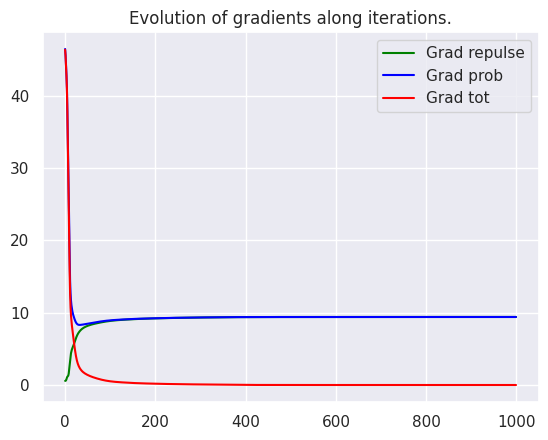

lambda = 0.004932090800447241


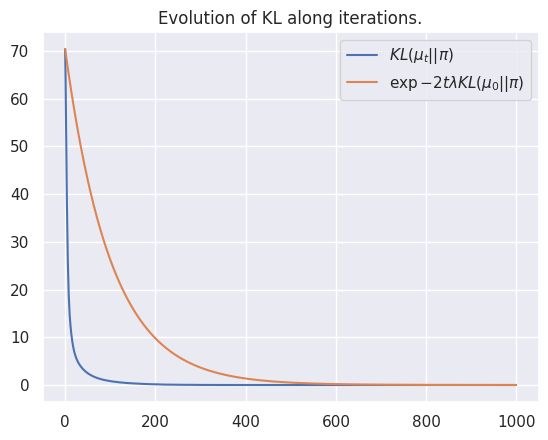

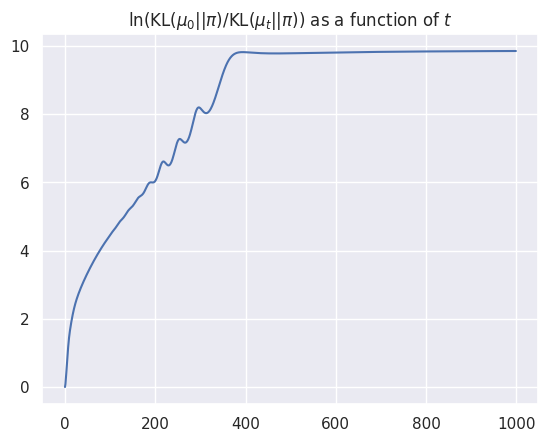

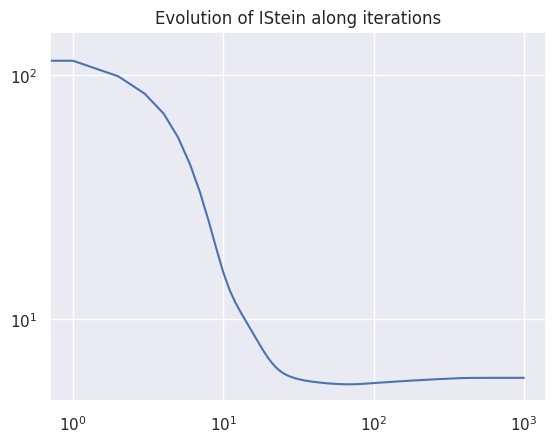

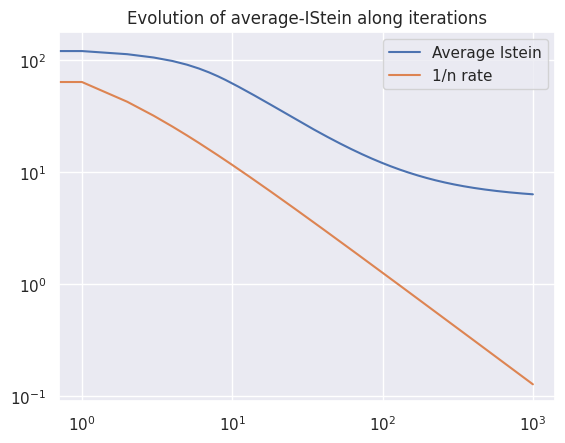

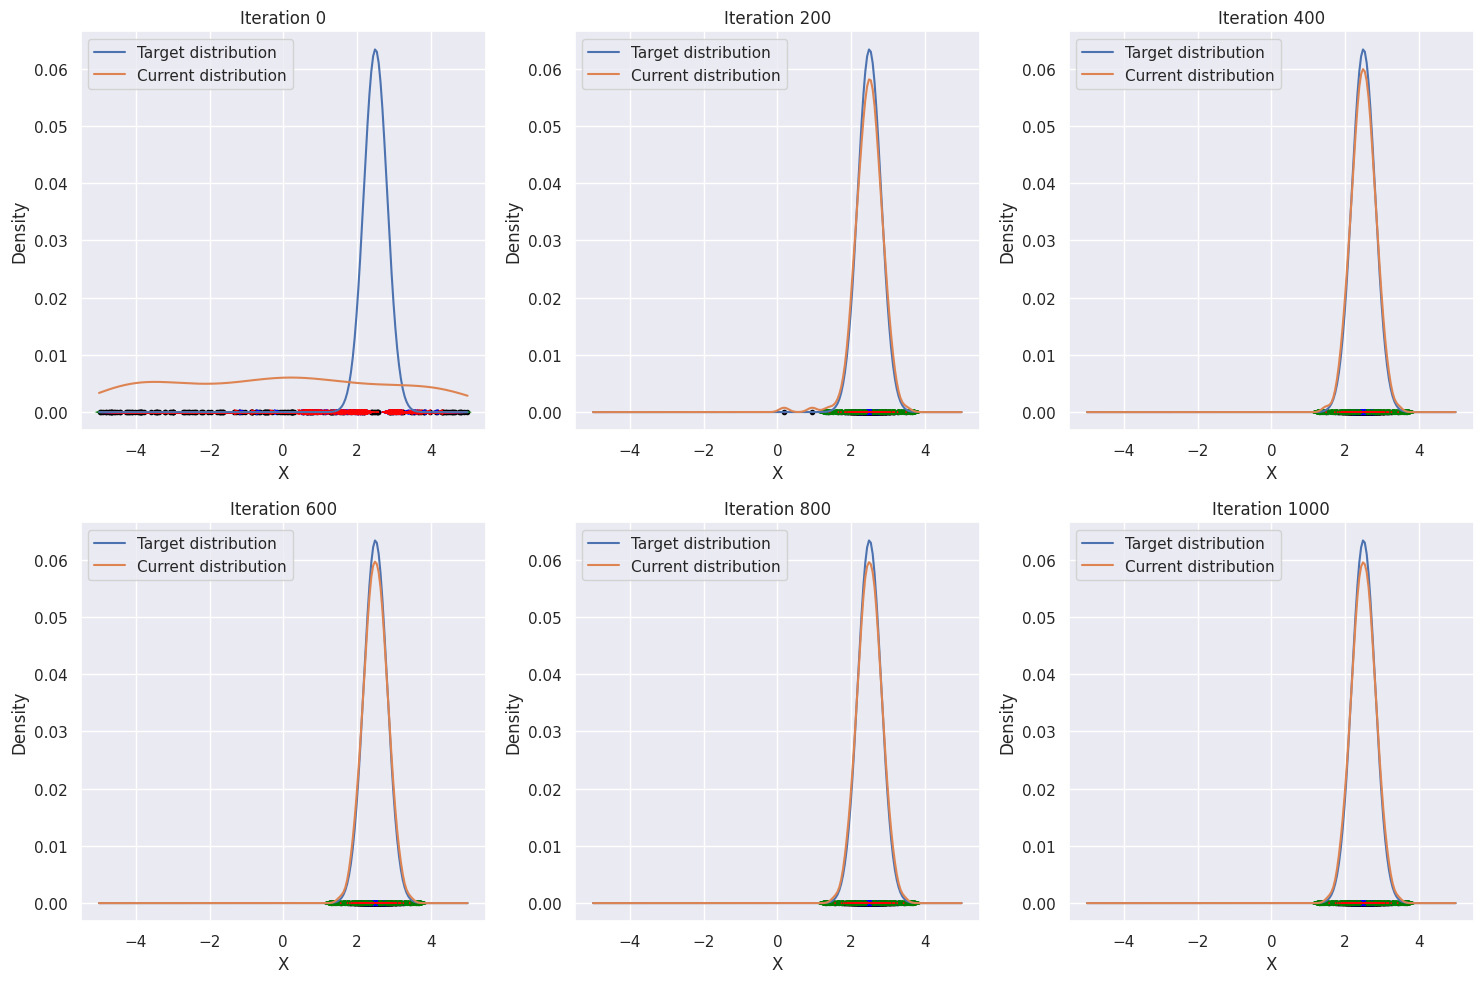

In [ ]:
d = 1
n = 200

#x = np.random.randn(n, d) + np.array([-1])
x = np.random.uniform(-1, 1, size=(n,d))*5

cov = np.eye(d)*0.1
mean = np.zeros(d)+2.5
target_distribution = Gaussian(mean=mean, cov=cov)


svgd = SVGD(x, target_distribution)
svgd.optimize(1000, lr=0.1, h=0.2, path='1d_gaussian')

MOG 1d

MOG 2G

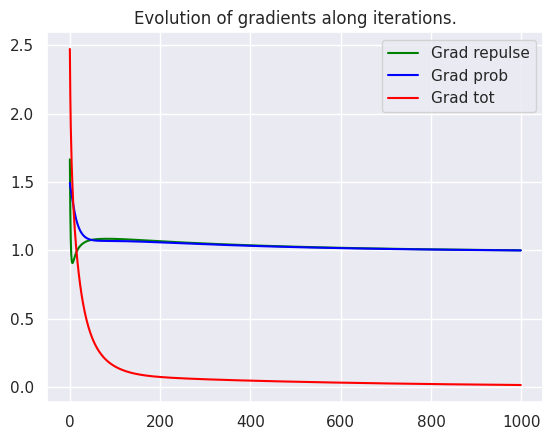

lambda = 0.000951082745065526


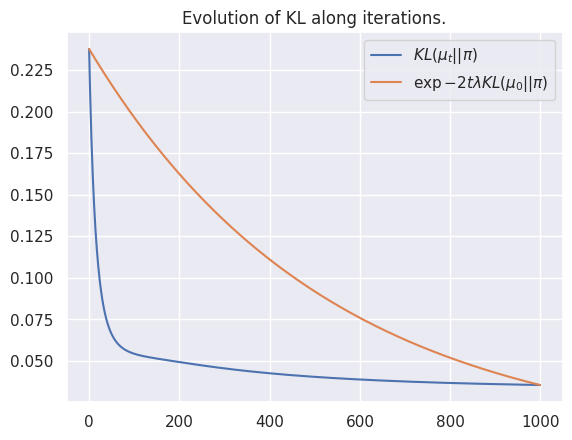

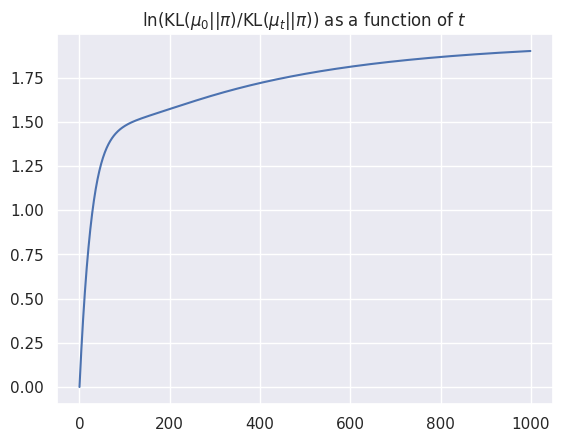

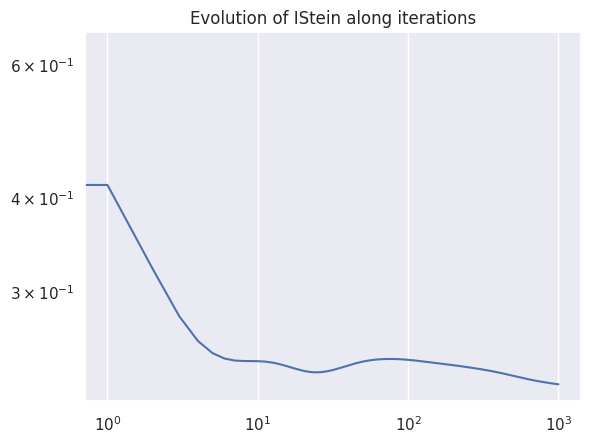

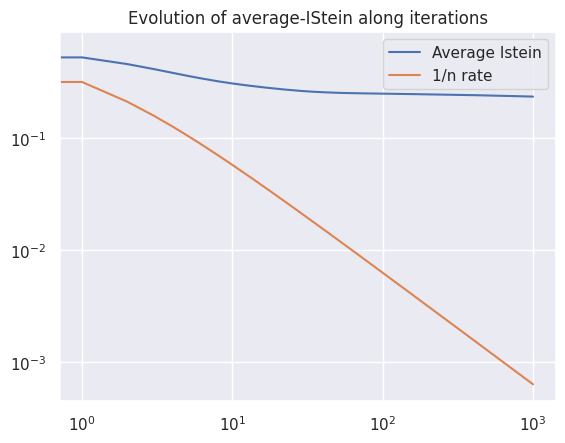

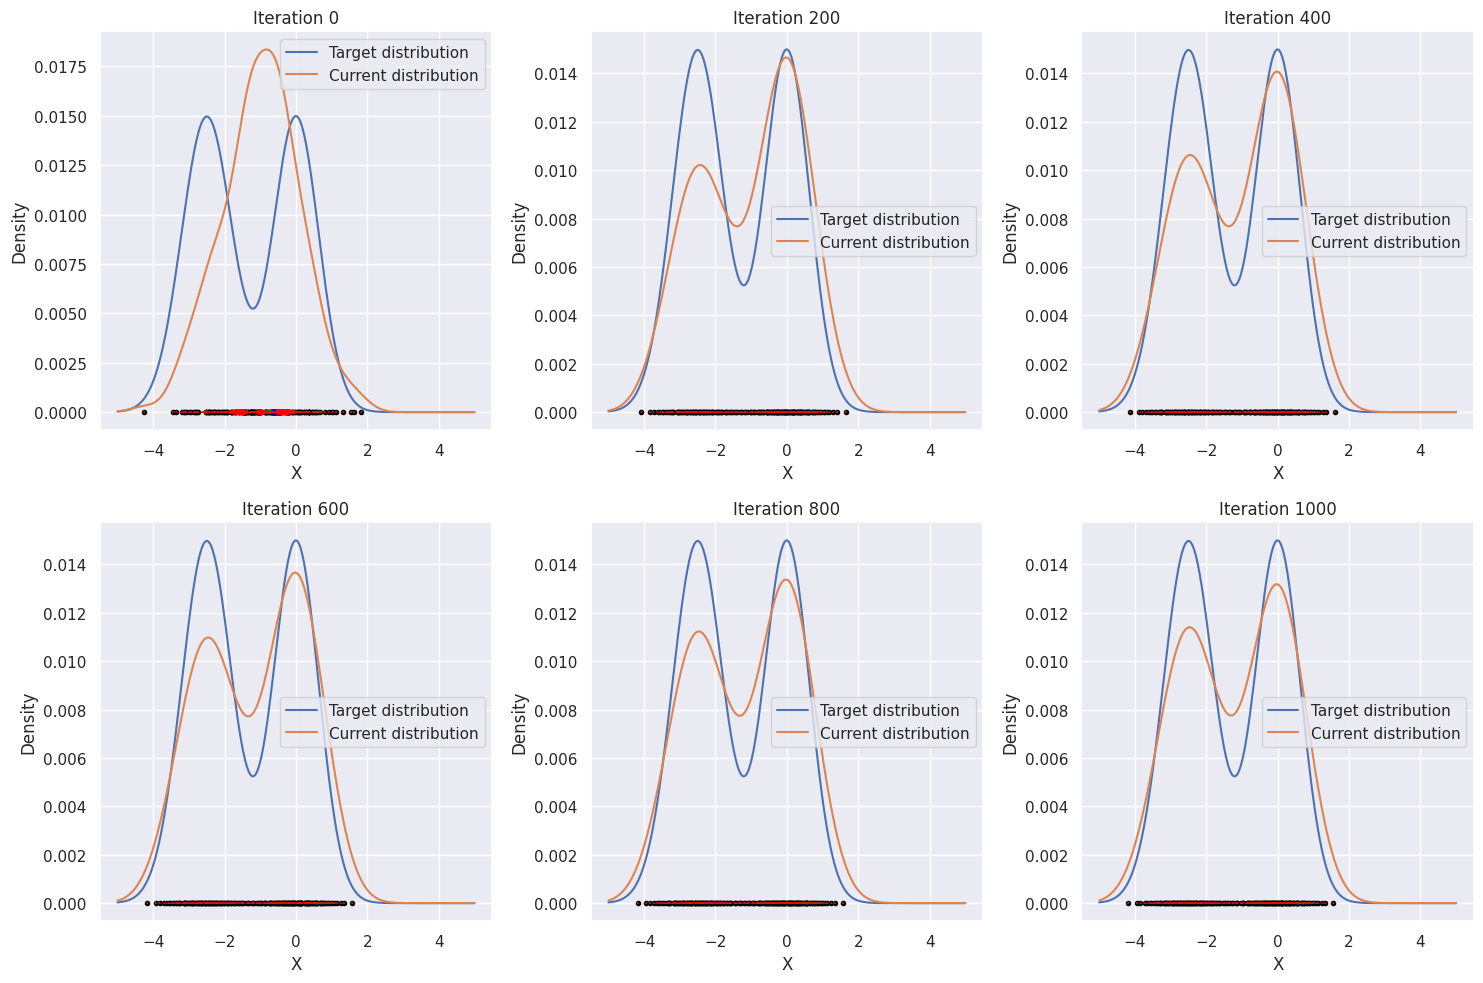

In [ ]:
d = 1
n = 200

#x = np.random.uniform(-1, 1, size=(n,d))*5
x = np.random.randn(n, d) + np.array([-1])

cov1 = np.eye(d)*0.5
mean1 = np.zeros(d)-2.5

cov2 = np.eye(d)*0.4
mean2 = np.zeros(d)

target_distribution = MoG(means=[mean1, mean2], covs=[cov1, cov2], weights=[2, 2, 1])


svgd = SVGD(x, target_distribution)
svgd.optimize(1000, lr=0.1, h=0.05, path='1d_mog')

MOG 3 G

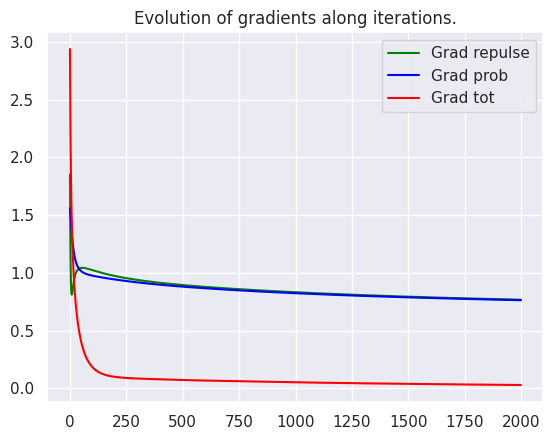

lambda = 0.0005012349907364683


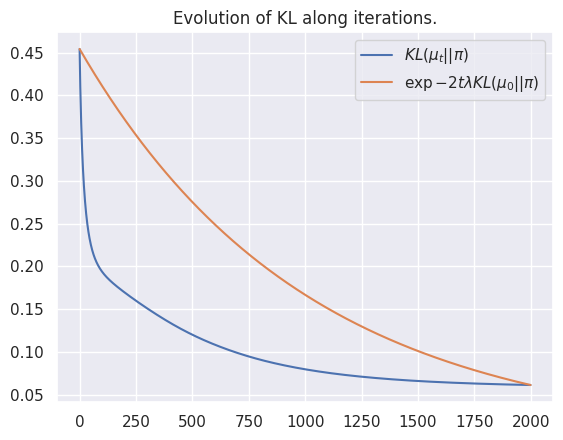

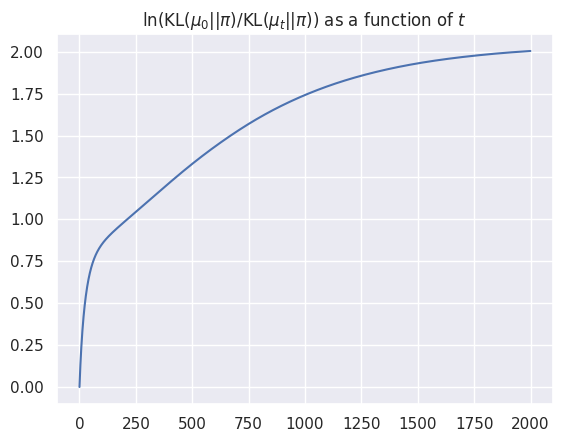

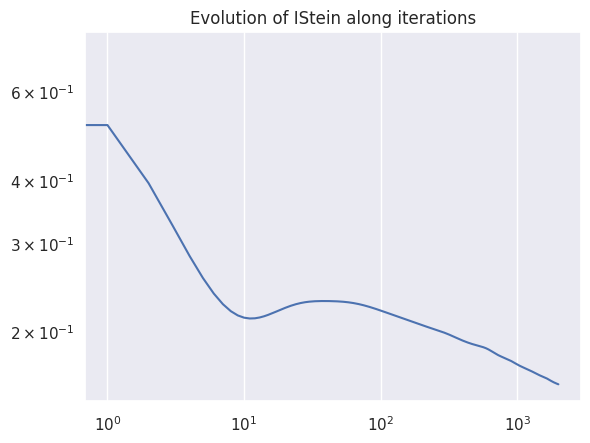

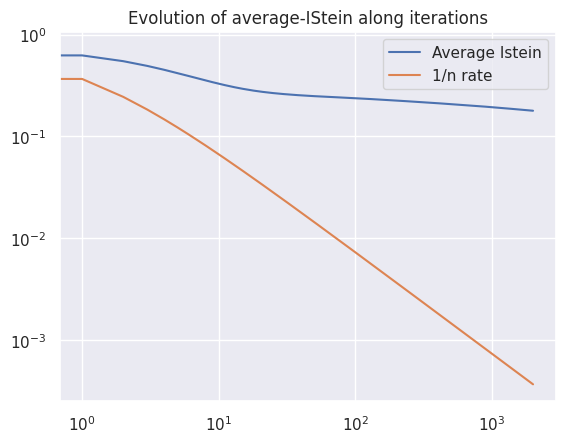

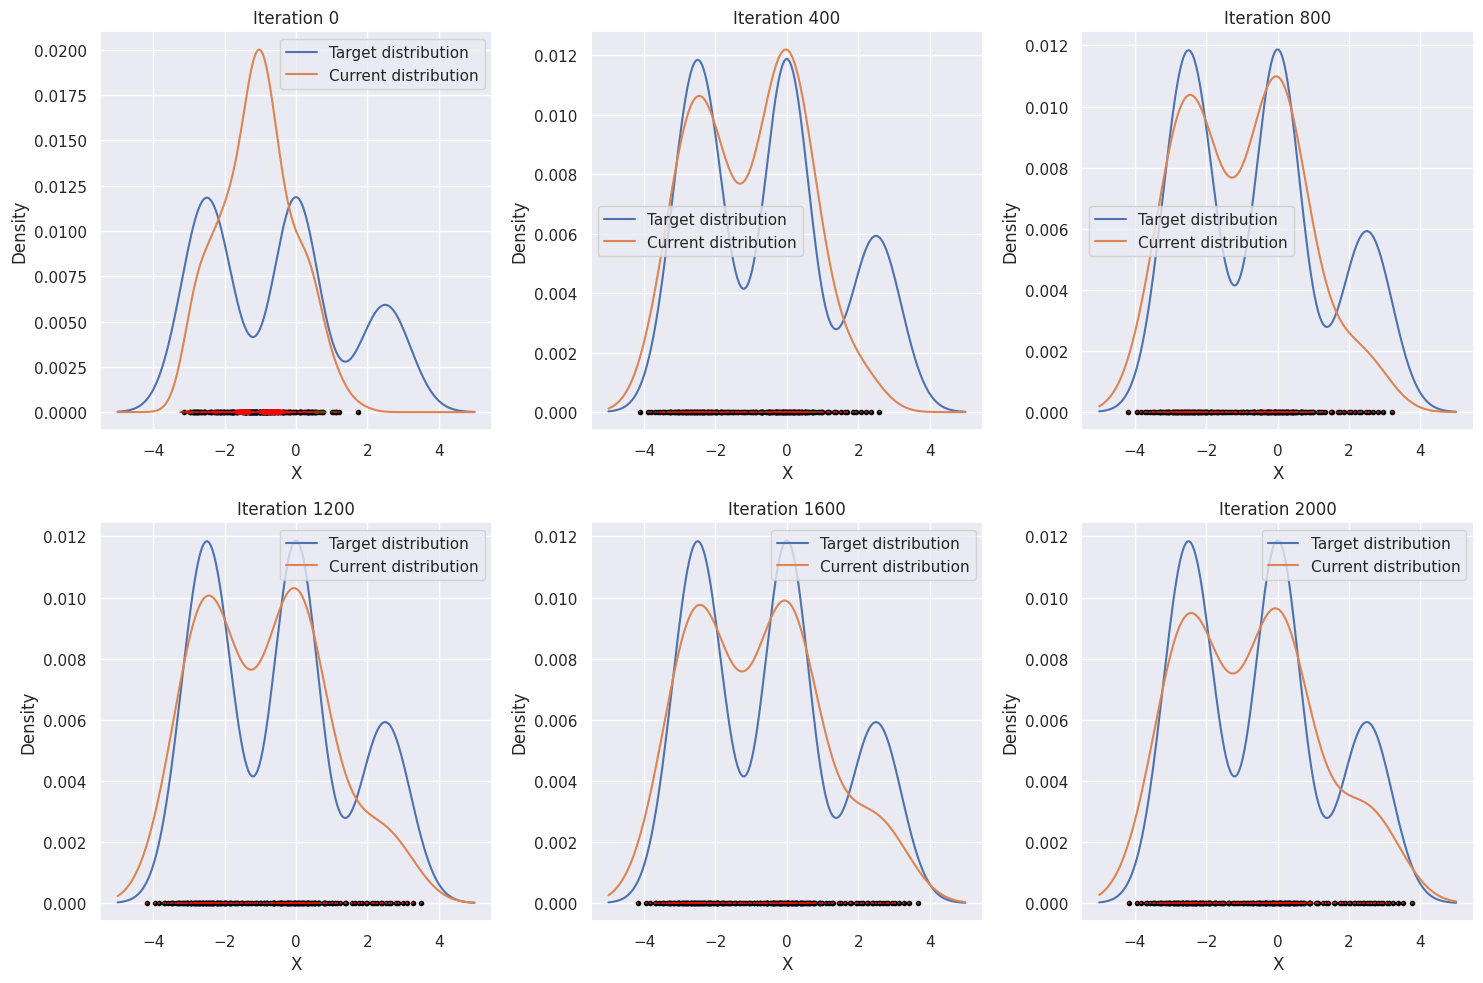

In [ ]:
d = 1
n = 200

#x = np.random.uniform(-1, 1, size=(n,d))*5
x = np.random.randn(n, d) + np.array([-1])

cov1 = np.eye(d)*0.5
mean1 = np.zeros(d)-2.5

cov2 = np.eye(d)*0.4
mean2 = np.zeros(d)

cov3 = np.eye(d)*0.5
mean3 = np.zeros(d)+2.5

target_distribution = MoG(means=[mean1, mean2, mean3], covs=[cov1, cov2, cov3], weights=[2, 2, 1])


svgd = SVGD(x, target_distribution)
svgd.optimize(2000, lr=0.1, h=0.05, path='1d_mog_hard')

#### Target distribution: 2D

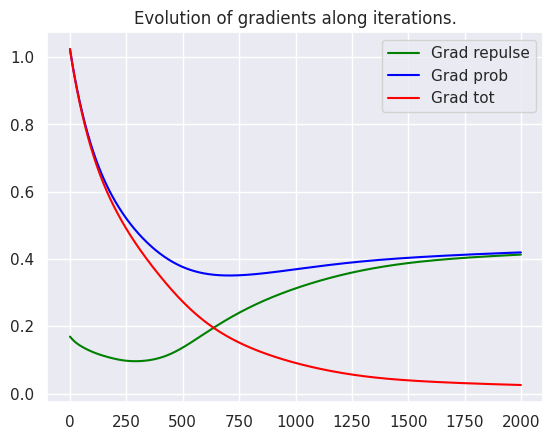

lambda = 0.0012688892947495512


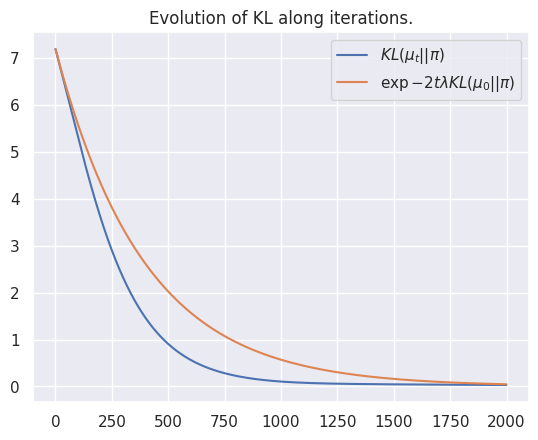

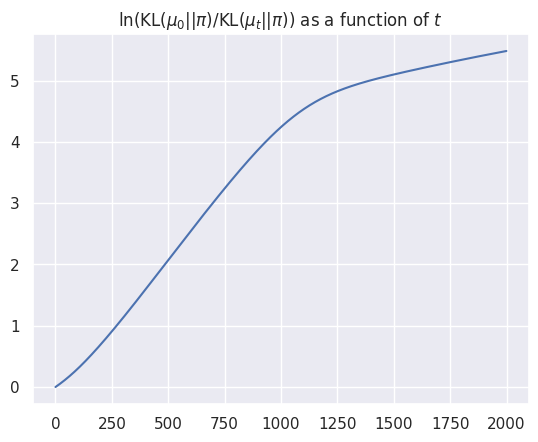

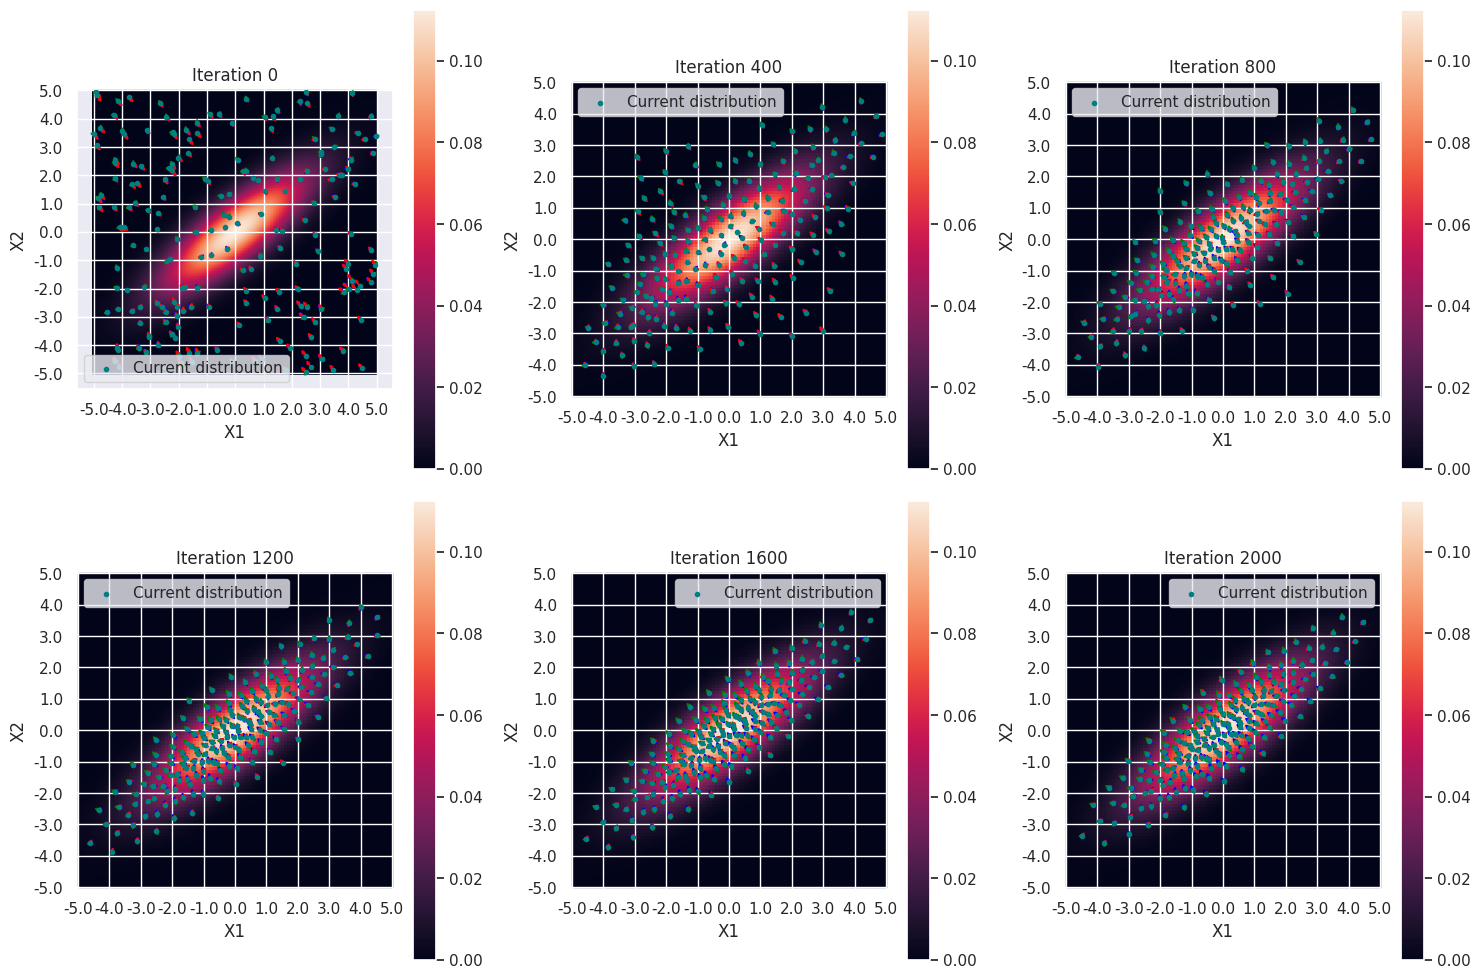

In [ ]:
d = 2
n = 200

x = np.random.randn(n, d) + np.array([-1, 1])
x = np.random.uniform(-1, 1, size=(n,d))*5

cov = np.array([[3, 2],[2, 2]])
target_distribution = Gaussian(cov=cov)


svgd = SVGD(x, target_distribution)
svgd.optimize(2000, lr=0.1, h=0.2, path='2d_gaussian')

#### Target distribution: mixture of multivariate gaussians

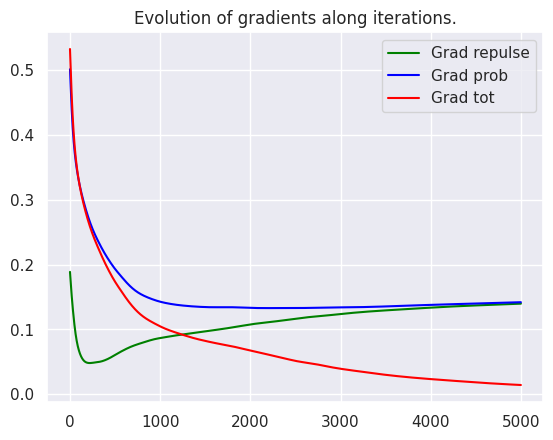

lambda = 0.000290292940754997


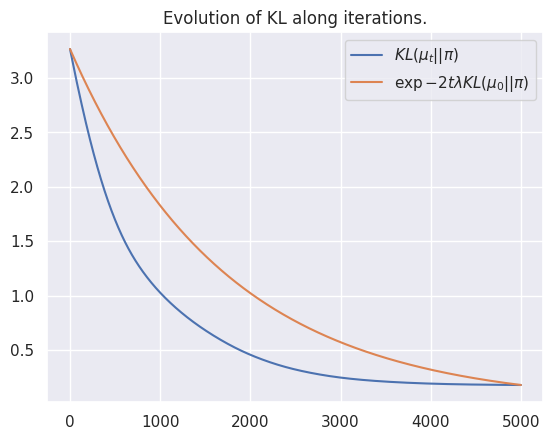

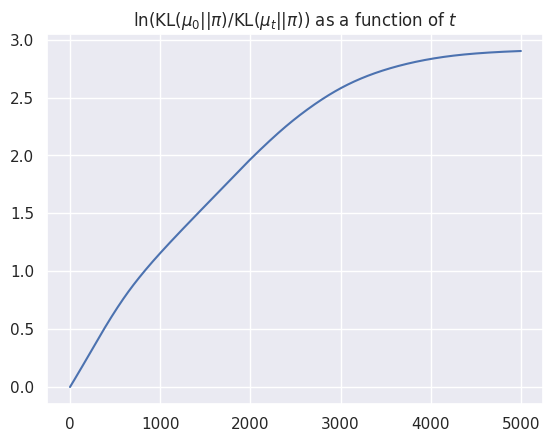

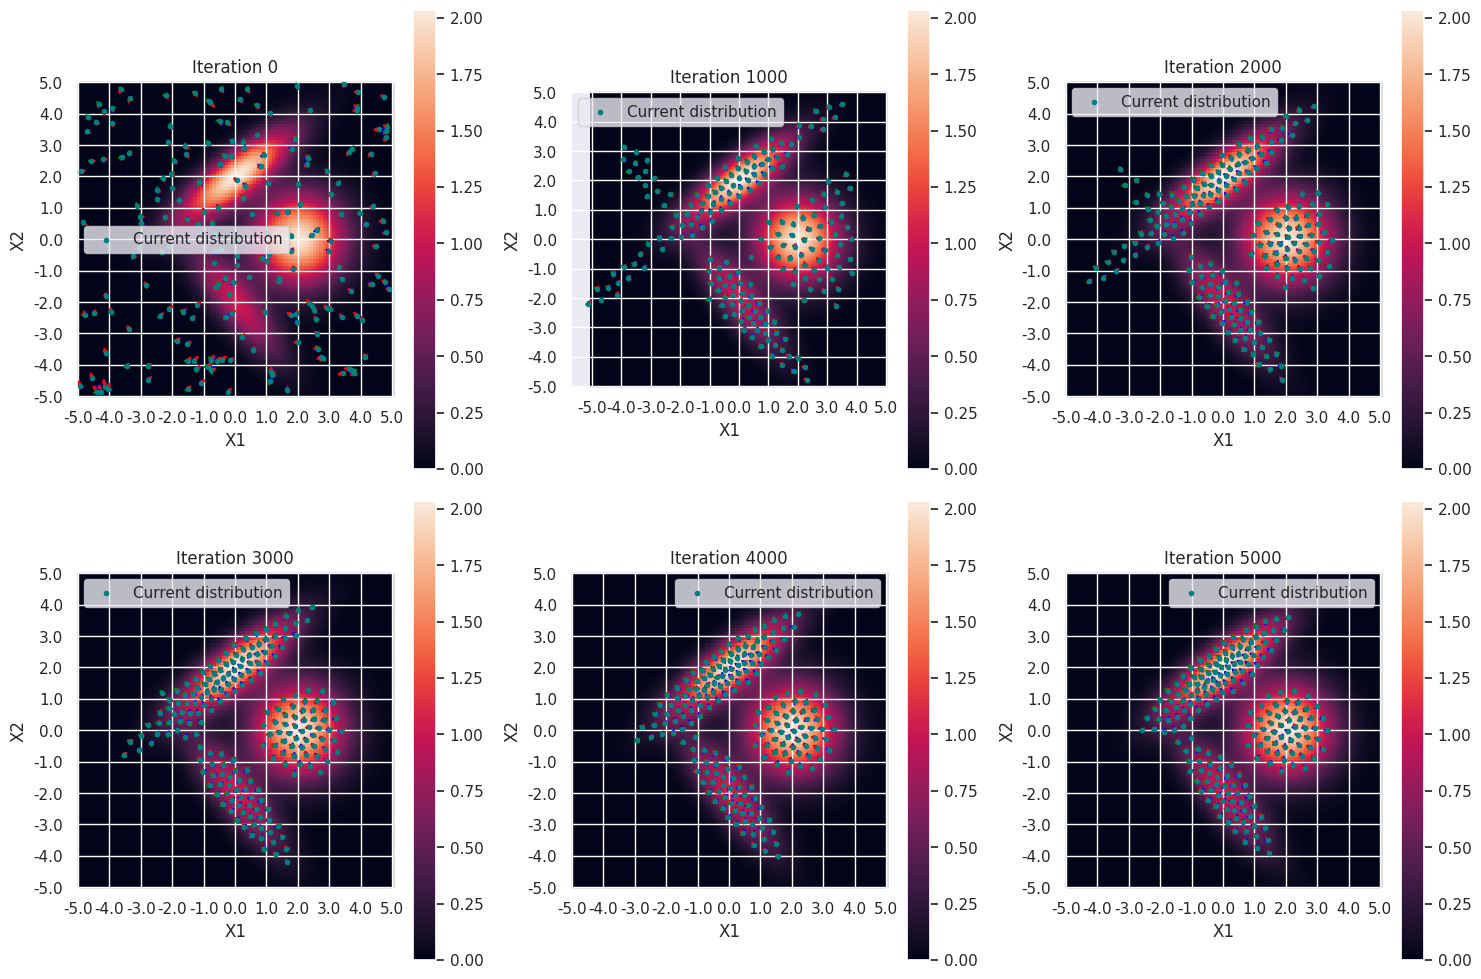

In [ ]:
d = 2
n = 200

x = np.random.uniform(-1, 1, size=(n,d))*5

mean1 = np.array([0, 2])
cov1 = np.array([[3, 2],[2, 2]])*0.5

mean2 = np.array([2, 0])
cov2 = np.eye(2)

mean3 = np.array([0, -2])
cov3 = np.array([[2, -2],[-2, 3]])*0.5

target_distribution = MoG(means=[mean1, mean2, mean3], covs=[cov1, cov2, cov3], weights=[2, 2, 1])

svgd = SVGD(x, target_distribution)
svgd.optimize(5000, lr=0.1, h=0.05, path='2d_mog')

#### Target distribution: circular shape

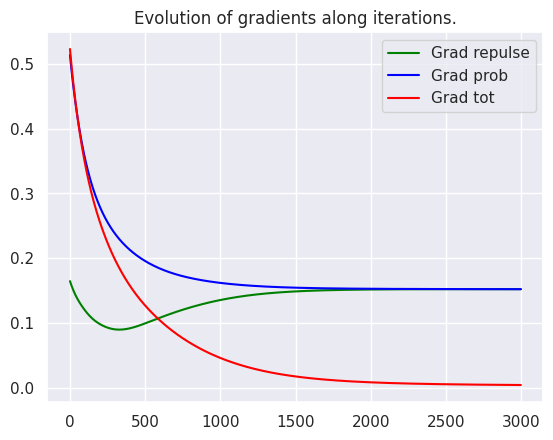

lambda = 0.00017359651810004785


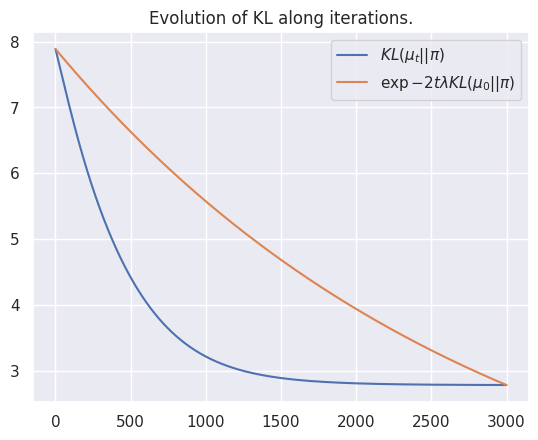

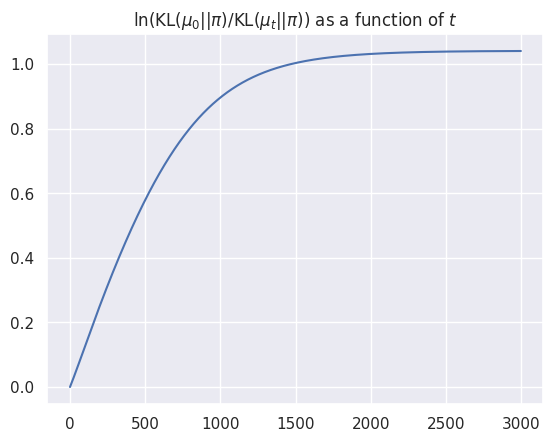

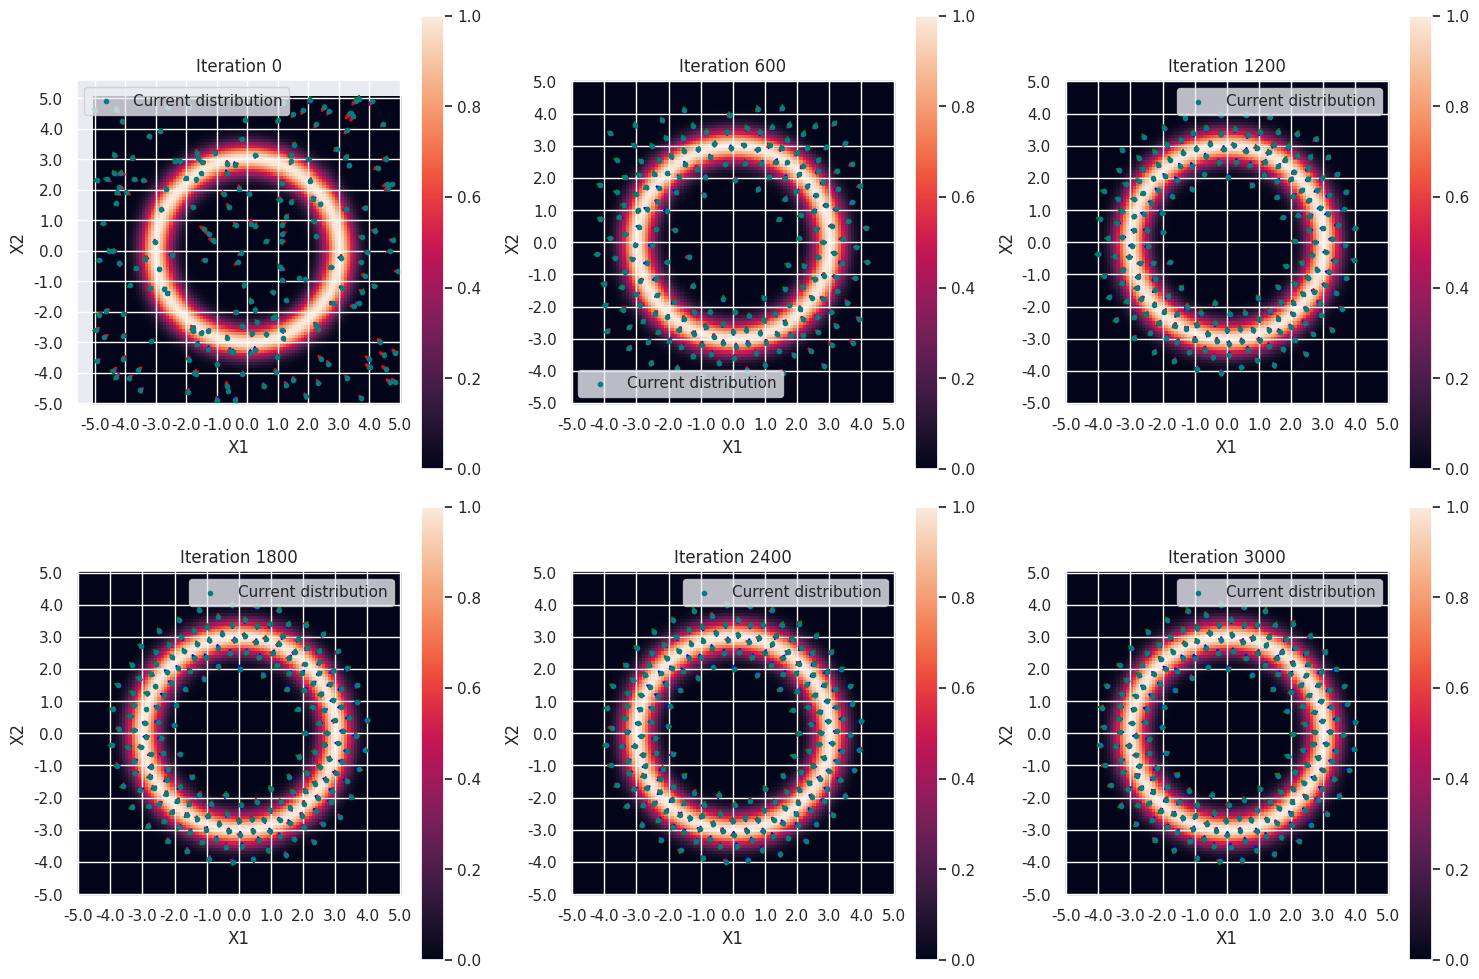

In [ ]:
d = 2
n = 200

x = np.random.randn(n, d) + np.array([-1, 1])
x = np.random.uniform(-1, 1, size=(n,d))*5

cov = np.array([[3, 2],[2, 2]])
target_distribution = CircleDist(R=3, alpha=0.5)


svgd = SVGD(x, target_distribution)
svgd.optimize(3000, lr=0.1, h=0.2, path='2d_circle')


Change of number of points

100%|██████████| 3000/3000 [05:27<00:00,  9.16it/s]


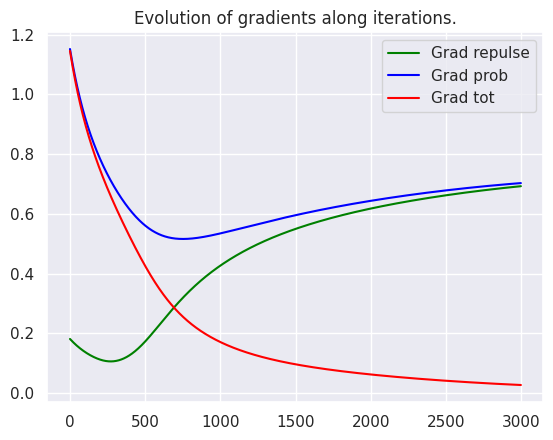

lambda = 0.0009268474369812944


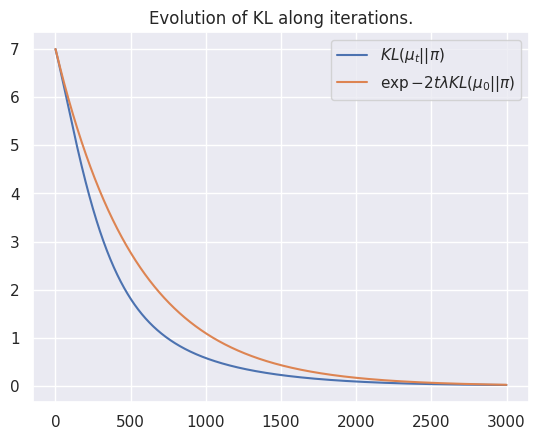

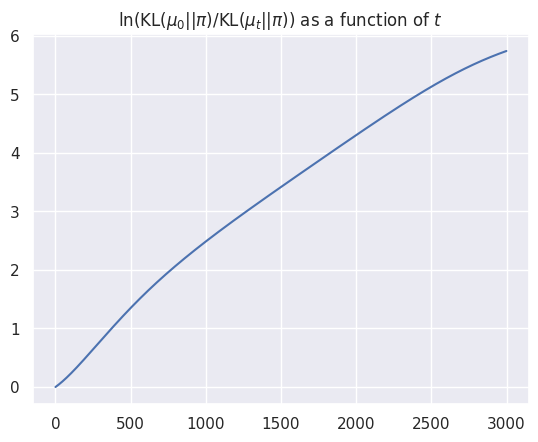

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


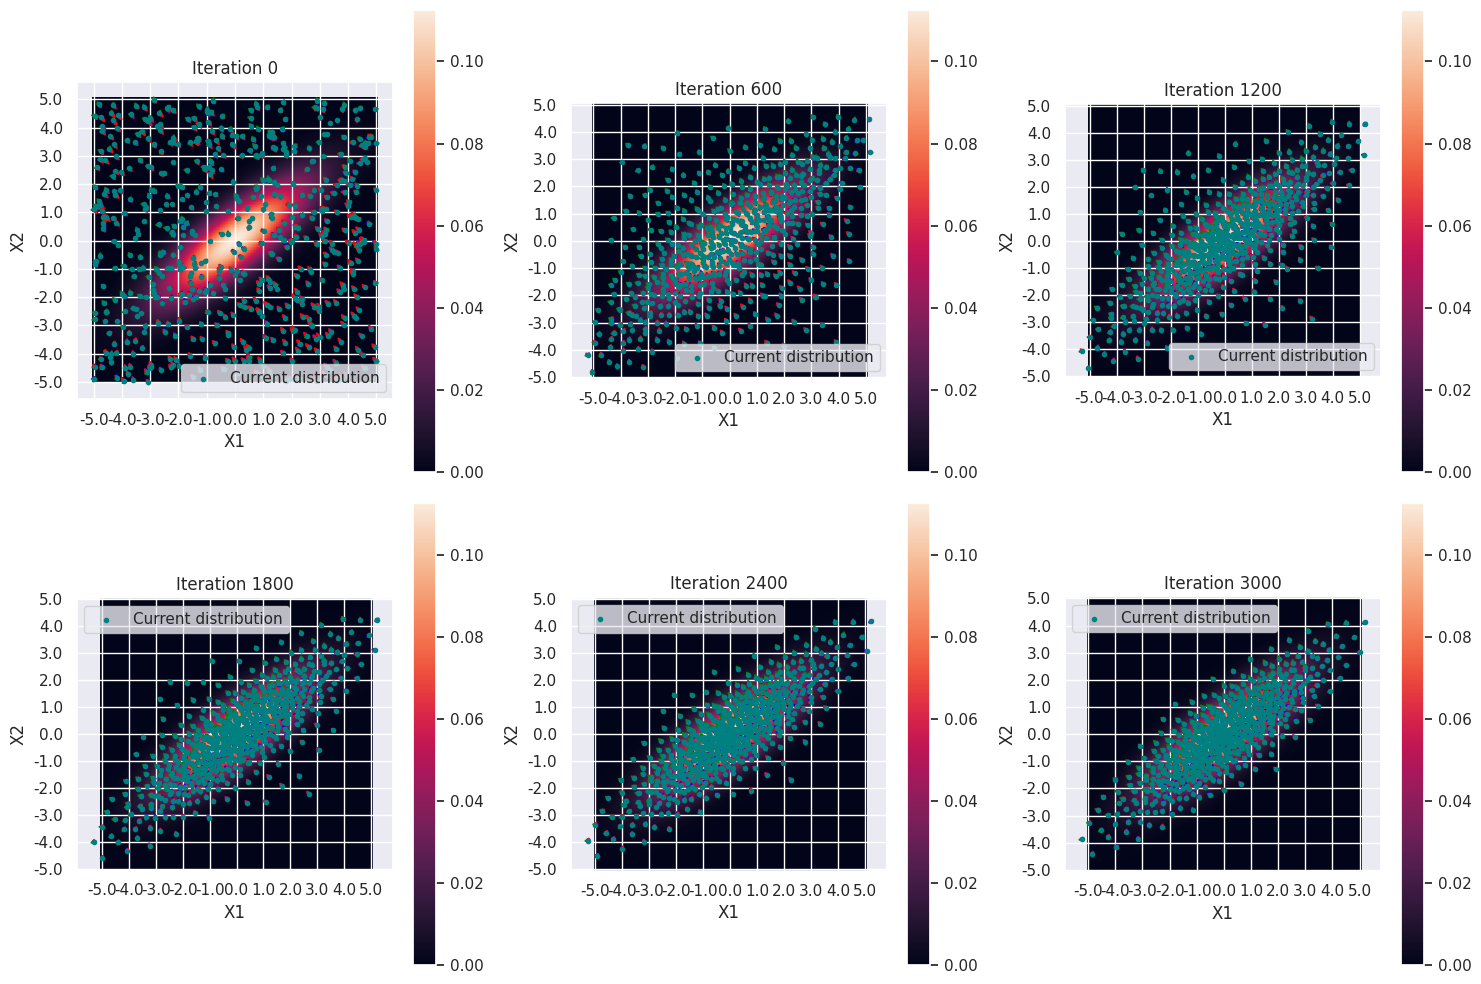

In [ ]:
d = 2
n = 600

x = np.random.randn(n, d) + np.array([-1, 1])
x = np.random.uniform(-1, 1, size=(n,d))*5

cov = np.array([[3, 2],[2, 2]])
target_distribution = Gaussian(cov=cov)


svgd = SVGD(x, target_distribution)
svgd.optimize(3000, lr=0.1, h=0.2, path='2d_gaussian_big_n')

Change of the dimension

100%|██████████| 2000/2000 [03:15<00:00, 10.21it/s]


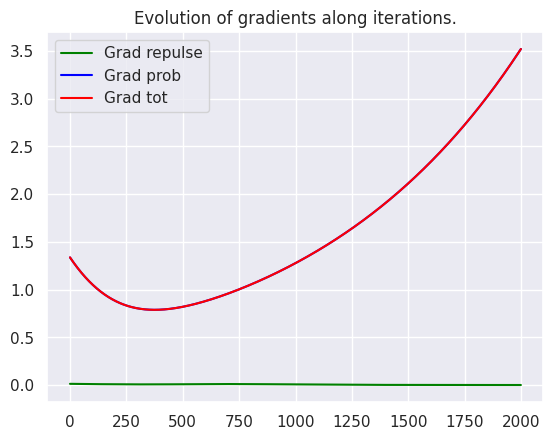

lambda = 0.00010932745092479805


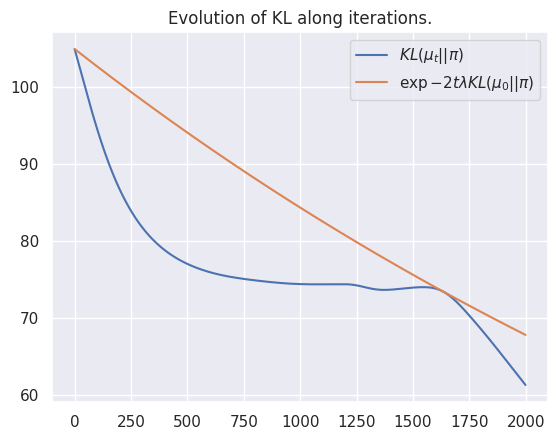

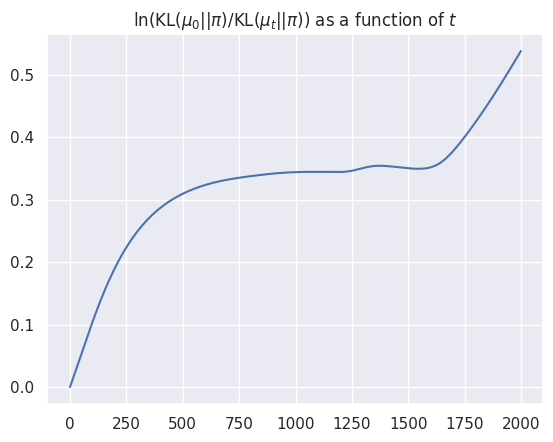

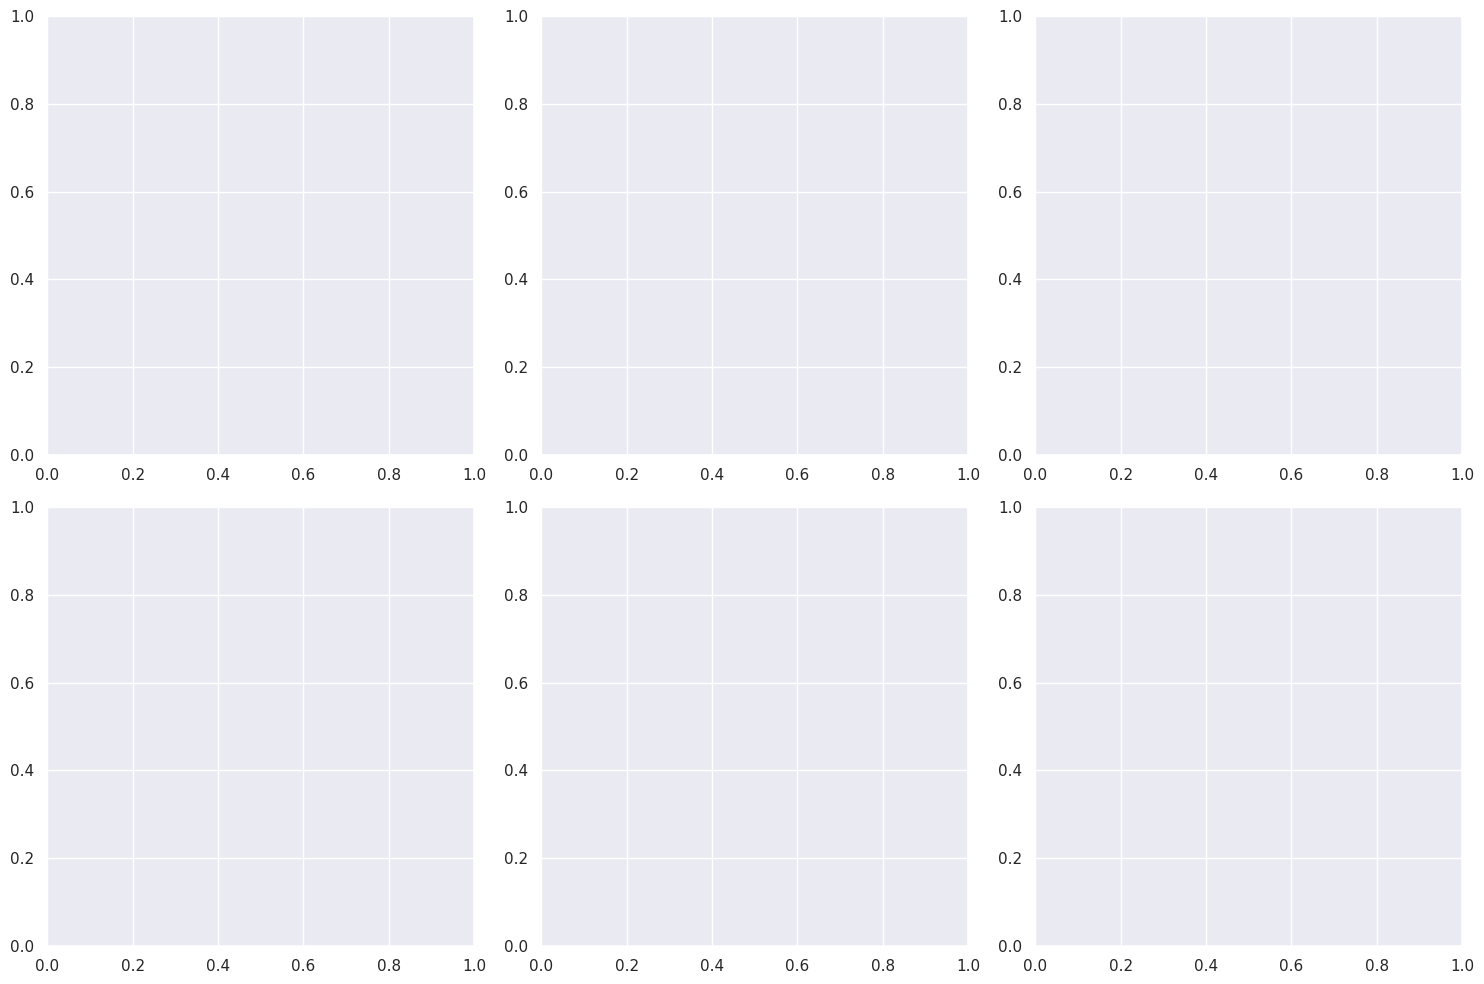

In [ ]:
d = 4
n = 200

#x = np.random.randn(n, d)
x = np.random.uniform(-1, 1, size=(n,d))*5

variances = np.random.uniform(1, 5, size=10)
covariances = np.random.uniform(-1, 1, size=(d, d))
covariances = np.tril(covariances)
covariances = covariances + covariances.T - np.diag(covariances.diagonal())
target_distribution = Gaussian(cov=covariances, mean=np.zeros(d))


svgd = SVGD(x, target_distribution)
svgd.optimize(2000, lr=0.1, h=0.2, path='4d_gaussian')

Change of h

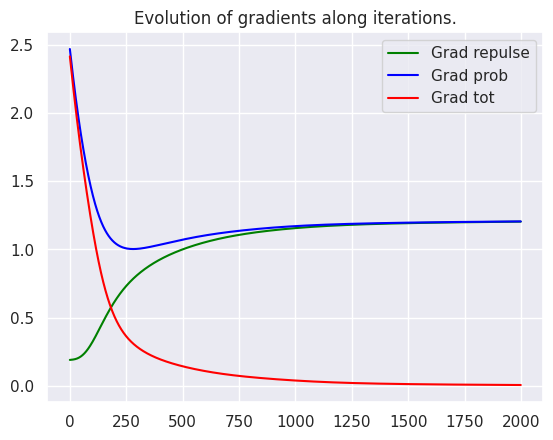

lambda = 0.0015375806058724652


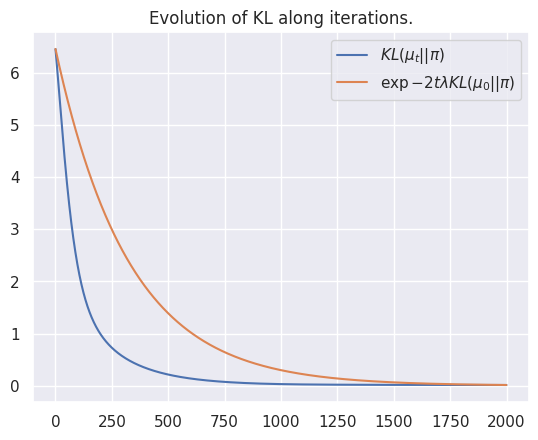

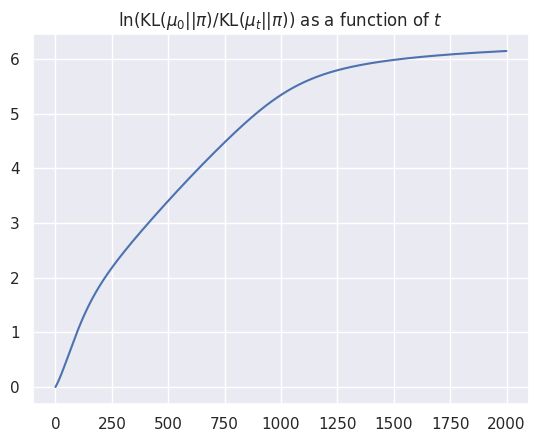

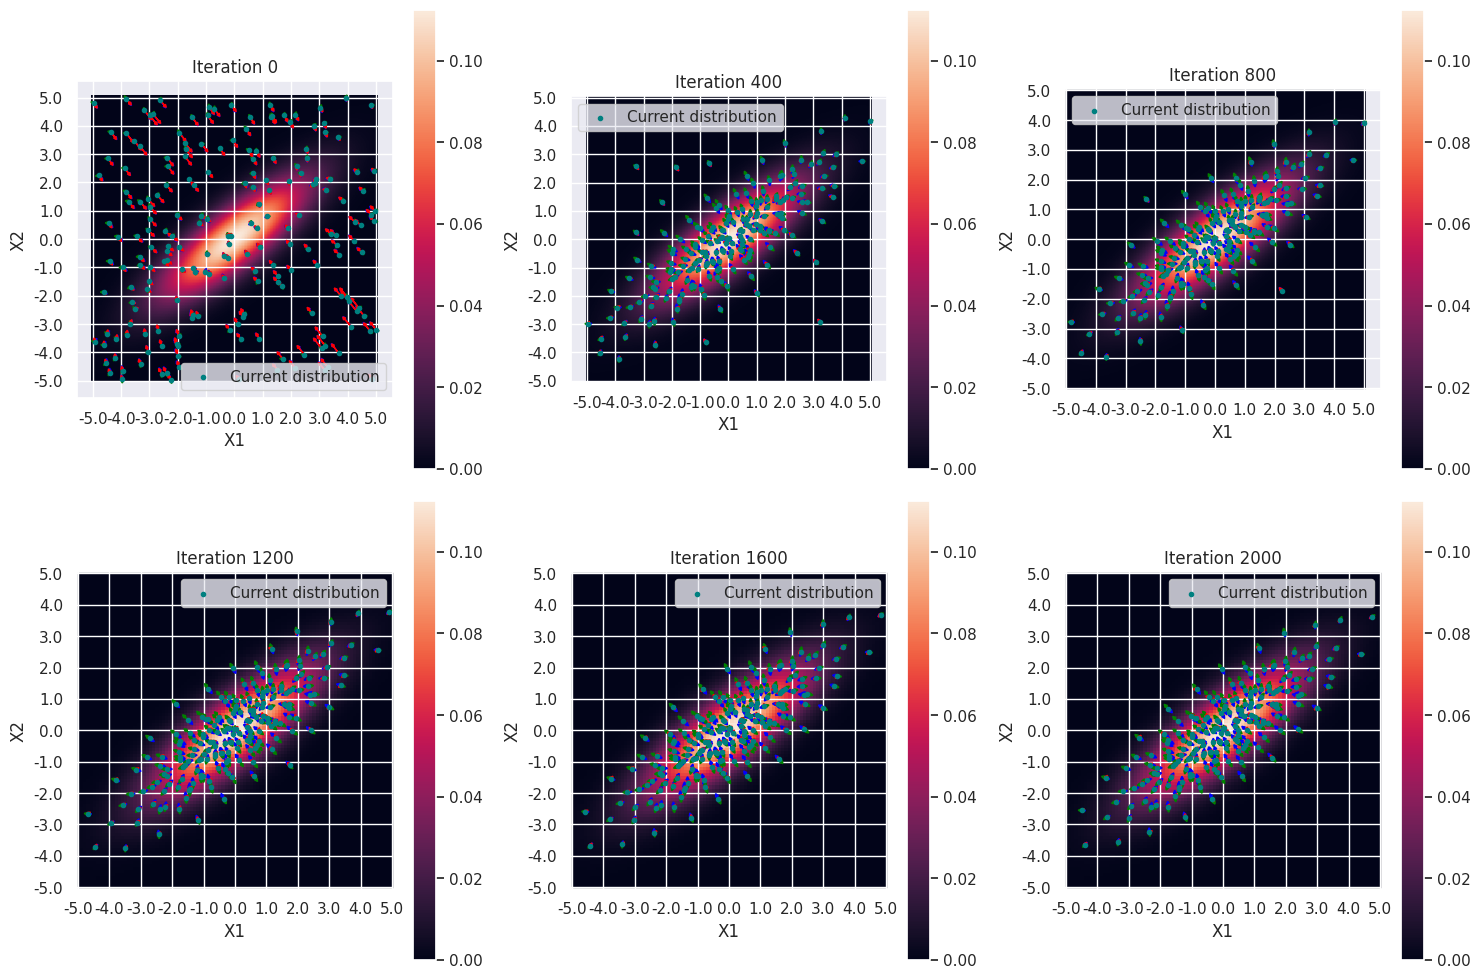

In [ ]:
d = 2
n = 200

x = np.random.randn(n, d) + np.array([-1, 1])
x = np.random.uniform(-1, 1, size=(n,d))*5

cov = np.array([[3, 2],[2, 2]])
target_distribution = Gaussian(cov=cov)


svgd = SVGD(x, target_distribution)
svgd.optimize(2000, lr=0.1, h=1, path='2d_gaussian_h_1')

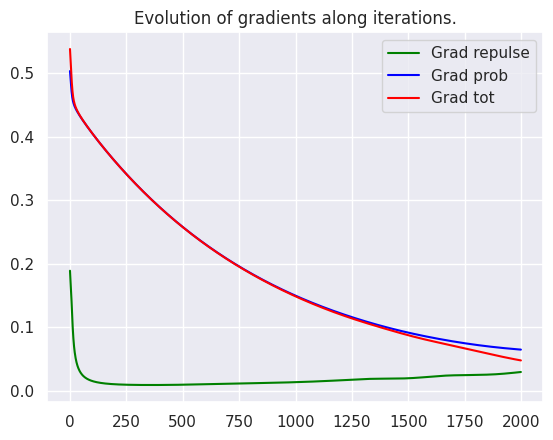

lambda = 0.0007260344208952142


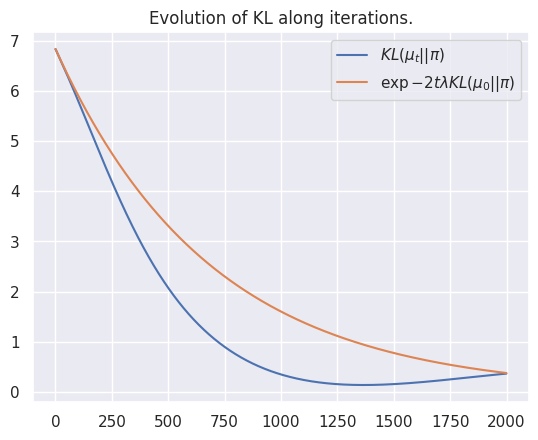

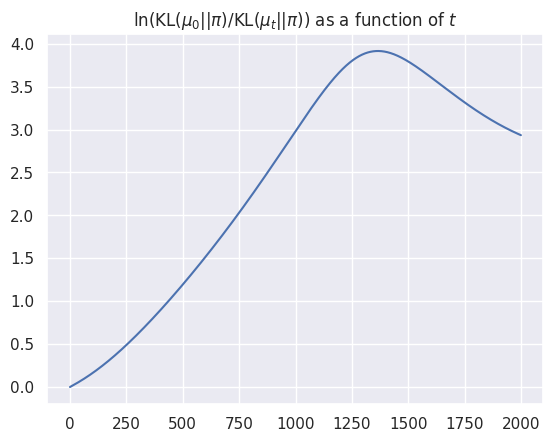

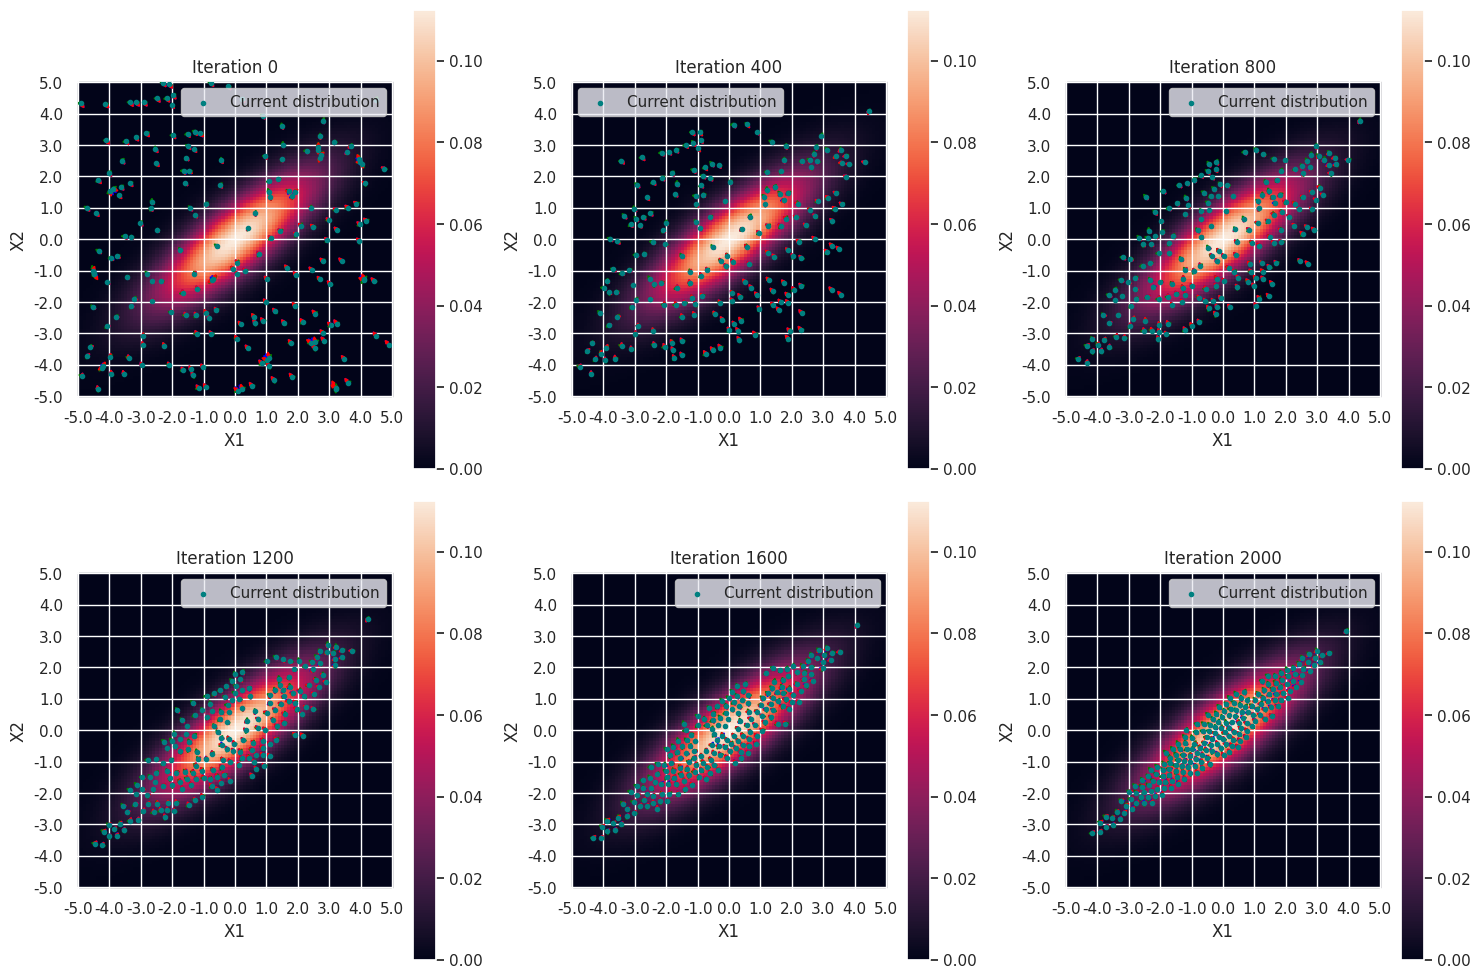

In [ ]:
d = 2
n = 200

x = np.random.randn(n, d) + np.array([-1, 1])
x = np.random.uniform(-1, 1, size=(n,d))*5

cov = np.array([[3, 2],[2, 2]])
target_distribution = Gaussian(cov=cov)


svgd = SVGD(x, target_distribution)
svgd.optimize(2000, lr=0.1, h=0.01, path='2d_gaussian_h_001')